In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Sinhala Handwritten Character Dataset

This example demonstrates how to use a Sinhala handwritten dataset to make predictions. Dataset contain seperate individula characters. The dataset is loaded into a notebook using ImageDataGenerator, and data augmentation is performed with TensorFlow. Finally, a Convolutional Neural Network (CNN) model is trained to make predictions.

![](https://storage.googleapis.com/kaggle-datasets-images/1513798/2500006/61e6c28ed4d7108f6b7034755d9a23c2/dataset-cover.png?t=2022-06-15-18-33-44)

# Importing all necessary packages

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow import keras
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2024-08-10 19:50:45.282631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 19:50:45.282731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 19:50:45.405845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading data using file path

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sathiralamal/sinhala-letter-454")

print("Path to dataset files:", path)

### Dataset Structure:
Ensure the dataset is organized into separate folders for train, test, and validation sets.
### Loading Data:
Load the data using the respective folder paths.
### Image Size Recommendation:
Recommended image size: 80x80 pixels.

In [3]:
train_path = '/kaggle/input/sinhala-letter-454/Dataset454/train'
valid_path = '/kaggle/input/sinhala-letter-454/Dataset454/valid'
test_path  = '/kaggle/input/sinhala-letter-454/Dataset454/test'

In [4]:
def draw_plot(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [5]:
img_height=80
img_weight=80

# Data lables and index in unicode format

### Class and Unicode Mapping:
This class includes a Unicode map of 454 Sinhala text representations in the index.
### Unicode Display:
Some text may display in Unicode without support. Use Singlish values as labels.
### Conversion to Unicode:
When using this index, consider converting Singlish values to Unicode with a separate layer.
### Array Index and Class Label:
Note that the array index and class label number are the same.

In [6]:
sinhala_classes=["අ","ආ","ඇ","ඈ","ඉ","ඊ","උ","එ","ඒ","ඔ","ඕ",
             "ක","කා","කැ","කෑ","කි","කී","කු","කූ","ක්","කෝ","ක්‍ර","ක්‍රි","ක්‍රී",
             "ග","ගා","ගැ","ගෑ","ගි","ගී","ගු","ගූ","ග්","ගෝ","ග්‍ර","ග්‍රි","ග්‍රී",
             "ච","චා","චැ","චෑ","චි","චී","චු","චූ","ච්","චෝ","ච්‍ර","ච්‍ර්","ච්‍රී",
             "ජ","ජා","ජැ","ජෑ","ජි","ජී","ජු","ජූ","ජ්","ජෝ","ජ්‍ර","ජ්‍රි","ජ්‍රී",
             "ට","ටා","ටැ","ටෑ","ටි","ටී","ටු","ටූ","ට්","ටෝ","ට්‍ර","ට්‍ර්","ට්‍රි"
             ,"ඩ","ඩා","ඩැ","ඩෑ","ඩි","ඩී","ඩු","ඩූ","ඩ්","ඩෝ","ඩ්‍ර","ඩ්‍ර්","ඩ්‍රි",
             "ණ","ණා","ණි",
             "ත","තා","ති","තී","තු","තූ","ත්","තෝ","ත්‍ර","ත්‍රා","ත්‍රි","ත්‍රී",
             "ද ","දා","දැ","දෑ","දි","දී","දු","දූ","ද්","දෝ","ද්‍ර","ද්‍රෝ","ද්‍රා","ද්‍රි","ද්‍රී",
             "න","නා","නැ","නෑ","නි","නී","නු","නූ","න්","නෝ","න්‍ර","න්‍රා","න්‍රි","න්‍රී",
             "ප","පා","පැ","පෑ","පි","පී","පු","පූ","ප්","ප්‍රෝ","පෝ","ප්‍ර","ප්‍රා","ප්‍රි","ප්‍රී",
             "බ","බා","බැ","බෑ","බි","බී","බු","බූ","බ්","බ්‍රෝ","බ්‍ර","බ්‍රා","බ්‍රි","බ්‍රී","බ්‍රෝ",
             "ම","මා","මැ","මෑ","මි","මී","මු","මූ","ම්","මෝ","ම්‍ර","ම්‍රා","ම්‍රි","ම්‍රී","ම්‍රෝ",
             "ය","යා","යැ","යෑ","යි","යී","යු","යූ","ෝ","ය්","hda",
             "ර","රා","රැ","රැ","රු","රූ","රි","රී",
             "ල","ලා","ලැ","ලෑ","ලි","ලී","ලු","ලූ","ල්",",da",
             "ව","වා","වැ","වෑ","වි","වී","වු","වූ","ව්","jda","ව්‍ර","ව්‍රා","ව්‍රැ","ව්‍රෑ","j%da",
             "ශ","ශා","ශැ","ශෑ","ශි","ශී","ශු","ශූ","ශ්","Yda","ශ්‍ර","ශ්‍රා","ශ්‍රැ","ශ්‍රෑ","ශ්‍රි","ශ්‍රී","Y%da",
             "ෂ","ෂා","ෂැ","ෂෑ","ෂි","ෂී","ෂු","ෂූ","ෂ්","Ida",
             "ස","සා","සැ","සෑ","සි","සී","සු","සූ","ida","ස්‍ර","ස්‍රා","ස්‍රි","ස්‍රී","ස්",
             "හ","හා","හැ","හෑ","හි","හී","හු","හූ","හ්","yda",
             "ළ","ළා","ළැ","ළෑ","ළි","ළී",
             "ළූ","ළූ",
             "ෆ","ෆා","ෆැ","ෆෑ","ෆි","ෆී","ෆූ","ෆූ","ෆ්‍ර","ෆ්‍රි","ෆ්‍රී","ෆ්‍රැ","ෆ්‍රෑ","ෆ්","*da",
             "ක්‍රා","ක්‍රැ","ක්‍රෑ","l%da",".%da",
             "ඛ","ඛා","ඛි","ඛී","ඛ්",
             "ඝ","ඝා","ඝැ","ඝෑ","ඝි","ඝී","ඝු","ඝූ",">da","ඝ්","ඝ්‍ර","ඝ්‍රා","ඝ්‍රි","ඝ්‍රී",
             "ඳ","ඳා","ඳැ","ෑ","ඳෑ","ඳි","ඳී","ඳු","ඳූ","|da "," ඳ්",
             "ඟ","ඟා","ඟැ"," ඟෑ"," ඟි","ඟී"," ඟු"," ඟූ","Õda","ඟ්",
             "ඬ","ැ","ඬා"," ඬැ", "ඬෑ"," ඬි","ඬී"," ඬු","ඬූ","ඬda "," ඬ්",
             "ඹ","ඹා"," ඹැ"," ඹෑ"," ඹි","ඹී"," ඹු","ඹූ","Uda","ඹ්",
             "භ","භා","භැ","භෑ","භි","භී","භු","භූ","Nda","භ්",
             "ධ","ධා","ධැ","ධෑ",",ධි",",ධී",",ධු",",ධූ","ධෝ","ධ්",
            "ඨ","ඨා","ඨැ","ඨි","ඨී","ඨු","ඨූ","ඨ්","ඪ","ඪා","ඪි","Vda",
             "ඵ","ඵා","ඵු","ඵි","Mda","ඵ් ","ථ","ථා","ථැ","ථ්","ා","ෟ","ණැ","ණෑ","ෘ","ණී","ණු","ණූ",
            "Kda","ණ්","ඥ","ඥා","{da","ඤ","ඤා","ඤු","[da","ඤ්","ඣ","ඣා","ඣු","COda",
             "ඣ්","ඦ","ඦා","ඦැ","ඦෑ","ඦි","ඦු","ඦූ","ඦෝ",
             "ඦ්","ඡ","ඡා","ඡැ","ඡෑ","ඡි","ඡේ","තැ","තෑ","ත්‍රැ","ත්‍රෑ",";%da",
             "ළු","ෲ","HQ","ff","f","H","Hq"
            
]

# Create data batches

In [7]:
train_batches = ImageDataGenerator().flow_from_directory(
    directory=train_path, target_size=(img_height,img_weight), batch_size=32 ,color_mode="grayscale")
valid_batches = ImageDataGenerator().flow_from_directory(
    directory=valid_path, target_size=(img_height,img_weight), batch_size=32,color_mode="grayscale")
test_batches = ImageDataGenerator().flow_from_directory(
    directory=test_path, target_size=(img_height,img_weight), batch_size=32,color_mode="grayscale", shuffle=False)

Found 87141 images belonging to 454 classes.
Found 10896 images belonging to 454 classes.
Found 10896 images belonging to 454 classes.


In [8]:
images,lables =next(train_batches)
lables[0].shape

(454,)

In [9]:
import keras.utils as image


# Data augmetaion layer define

In [10]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(img_height, img_height),
  tf.keras.layers.Rescaling(1./255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
   tf.keras.layers.RandomRotation(0.1,fill_mode="constant",seed=20),

])

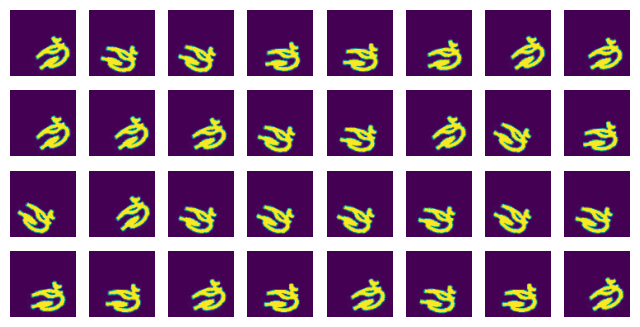

In [12]:
plt.figure(figsize=(8, 4))
for i in range(32):
    augmented_image = data_augmentation(images)
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

# Model architecture creation

In [13]:
def create_model():
    model= Sequential([
    Input(shape=(img_height,img_height,1)), 
    resize_and_rescale,
#     data_augmentation,
    Conv2D(filters =32 , kernel_size= (7,7) ,activation = 'relu' ,padding='same' ),
    Conv2D(filters =32 , kernel_size= (7,7) ,activation = 'relu' ,padding='same' ),
#     BatchNormalization() ,
    MaxPool2D(pool_size=(8,8) ,strides=(2,2) ),
    
    Conv2D(filters =64 , kernel_size= (7,7) ,activation = 'relu' ,padding='same'),
    Conv2D(filters =64 , kernel_size= (7,7) ,activation = 'relu' ,padding='same'),
    MaxPool2D(pool_size=(2,2) ,strides=(2,2) ),
        
    Conv2D(filters =128 , kernel_size= (7,7) ,activation = 'relu' ,padding='same'),
        
        
    Flatten(),
    Dense(units=1000, activation='relu'),

    Dense(units=len(sinhala_classes), activation='softmax')
    
    ])
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modle training 

In [14]:
def model_train(model,save_name,epoch):
    history=model.fit(
    x=train_batches, 
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    epochs=epoch,
    verbose=0)
    
    draw_plot(history)
    
    model.save(save_name+'.h5')
    model.evaluate(test_batches)

In [15]:
model =create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 80, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 80, 80, 32)     │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │    41,473,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 454)            │       454,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,681,982 (162.82 MB)

 Trainable params: 42,681,982 (162.82 MB)

 Non-trainable params: 0 (0.00 B)

# Save and Train model

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723319478.475529      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723319478.498078      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723319803.837588      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723320039.023509      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723320127.066971      94 graph_launch.cc:671] Fallback to op-by-op mode because mems

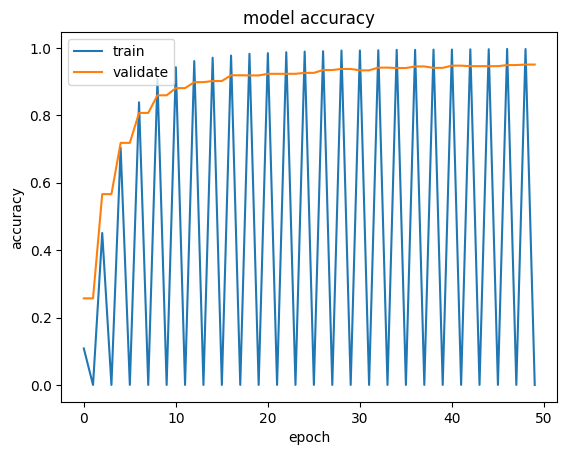

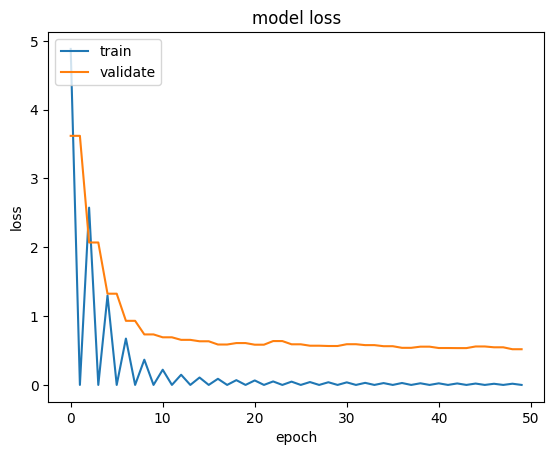

341/341 ━━━━━━━━━━━━━━━━━━━━ 75s 220ms/step - accuracy: 0.9519 - loss: 0.5080


In [16]:
model_train(model,'model_test',50)